In [1]:
from vyper.user import Model
import pandas as pd
from sklearn.utils import shuffle
from vyper.user.explorer import DataProfiler
from openpyxl import Workbook

import math
import numpy as np
from vyper.utils.tools import StatisticalTools as st
from sklearn.preprocessing import OrdinalEncoder
import scipy as stats
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from varclushi import VarClusHi
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
from sklearn.cluster import Birch
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer, silhouette_score
from sklearn.decomposition import PCA
from matplotlib.cm import viridis

In [3]:
class birch:
    def __init__(self, data):
        self.df = pd.read_csv(data)
        # self.df = self.df.iloc[:50000, :]

    def get_shape(self):
        return self.df.shape

    def get_df(self):
        return self.df

    @staticmethod
    def silhouette(estimator, df, metric='euclidean'):
        labels = estimator.fit_predict(df)
        score = silhouette_score(df, labels, metric=metric)
        return score

    @staticmethod
    def get_training_history(training_history):
        return pd.DataFrame.from_dict(training_history)

    def gridSearchCV_birch(self, grid, cv=5, rand_sample_prop=0.2):
        sample_data = self.df.sample(frac=rand_sample_prop)
        birch = Birch()
        grid_search = GridSearchCV(estimator=birch, param_grid=grid, cv=cv, scoring=self.silhouette)
        grid_search.fit(sample_data)
        # grid_search.fit(self.df)
        return grid_search.best_score_, grid_search.best_params_, grid_search.cv_results_

    def randomizedSearchCV_birch(self, grid, cv=5, n_iter=10, rand_sample_prop=0.2):
        # fd = self.create_folds(cv)
        sample_data = self.df.sample(frac=rand_sample_prop)
        birch = Birch()
        random_search = RandomizedSearchCV(estimator=birch, param_distributions=grid, cv=cv, scoring=self.silhouette,
                                           n_iter=n_iter)
        random_search.fit(sample_data)
        return random_search.best_score_, random_search.best_params_, random_search.cv_results_

    def birch(self, branching_factor, n_clusters, threshold):
        birch = Birch(branching_factor=branching_factor, n_clusters=n_clusters, threshold=threshold)
        clusters = birch.fit_predict(self.df) + 1
        return clusters

    def pca(self, clusters, n_components=2):
        pca = PCA(n_components=n_components)
        principalComponents = pca.fit_transform(self.df)
        principalComponents = pd.DataFrame(data=principalComponents, index=self.df.index, columns=['PC1', 'PC2'])
        principalComponents['cluster'] = clusters
        return principalComponents

    @staticmethod
    def scatter_plot(principalComponents):
        plt.scatter(principalComponents['PC1'], principalComponents['PC2'], c=principalComponents['cluster'],
                    cmap=viridis)
        plt.show()

In [4]:
folds = 5
params_grid = {"branching_factor": [50, 100, 200, 300, 400, 500],
               "n_clusters": list(range(2, 10)),
               "threshold": [0.2, 0.3, 0.4, 0.5]}

In [5]:
bi=birch('maurices_oc_preprocessed.csv')

In [6]:
bi.get_shape()

(99942, 13)

In [7]:
import time
start_time = time.time()
# a,b,c=bi.gridSearchCV_birch(params_grid, folds, 0.2)
a,b,c=bi.randomizedSearchCV_birch(params_grid, folds, 10, 0.2)
end_time = time.time()
print(end_time - start_time)

225.58719897270203


Rows  ||  Runtime of randomizedSearchCV_birch
1000  ||  0.606
5000  ||  5.06
10000 ||  10.89
30000 ||  29.75
50000 || 66.17
total || 292.19

In [8]:
branching_factor = b['branching_factor']
n_clusters = b['n_clusters']
threshold = b['threshold']

In [9]:
bi.get_training_history(c)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_threshold,param_n_clusters,param_branching_factor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.430374,0.221987,0.617963,0.026319,0.4,7,400,"{'threshold': 0.4, 'n_clusters': 7, 'branching...",0.361694,0.197952,0.365760,0.204392,0.203421,0.266644,0.079309,8
1,4.053212,0.349424,0.675020,0.119049,0.3,5,200,"{'threshold': 0.3, 'n_clusters': 5, 'branching...",0.373666,0.411312,0.360344,0.195669,0.204907,0.309180,0.090515,6
2,3.708675,0.297546,0.635786,0.092582,0.4,7,100,"{'threshold': 0.4, 'n_clusters': 7, 'branching...",0.359902,0.394467,0.446561,0.197640,0.205693,0.320853,0.101183,4
3,4.879555,0.374706,0.729473,0.078873,0.3,9,50,"{'threshold': 0.3, 'n_clusters': 9, 'branching...",0.208057,0.204441,0.211854,0.211632,0.208373,0.208871,0.002722,9
4,4.402259,0.049633,0.678521,0.020463,0.3,8,500,"{'threshold': 0.3, 'n_clusters': 8, 'branching...",0.212767,0.200099,0.213083,0.206460,0.202870,0.207056,0.005200,10
5,3.785173,0.116449,0.617724,0.017827,0.4,7,50,"{'threshold': 0.4, 'n_clusters': 7, 'branching...",0.321356,0.478064,0.404246,0.190745,0.208645,0.320611,0.110624,5
6,2.799396,0.120284,0.575471,0.032250,0.5,8,200,"{'threshold': 0.5, 'n_clusters': 8, 'branching...",0.384234,0.201990,0.353777,0.197098,0.201620,0.267744,0.083257,7
7,2.819633,0.308140,0.596811,0.088869,0.5,2,400,"{'threshold': 0.5, 'n_clusters': 2, 'branching...",0.661844,0.617072,0.622338,0.576552,0.696297,0.634821,0.040929,1
8,5.426773,0.444657,0.753081,0.046035,0.2,2,400,"{'threshold': 0.2, 'n_clusters': 2, 'branching...",0.674163,0.618610,0.605407,0.551376,0.662816,0.622474,0.043955,2
9,2.591923,0.039377,0.536594,0.010746,0.5,3,400,"{'threshold': 0.5, 'n_clusters': 3, 'branching...",0.621064,0.592176,0.555664,0.538966,0.469983,0.555571,0.051440,3


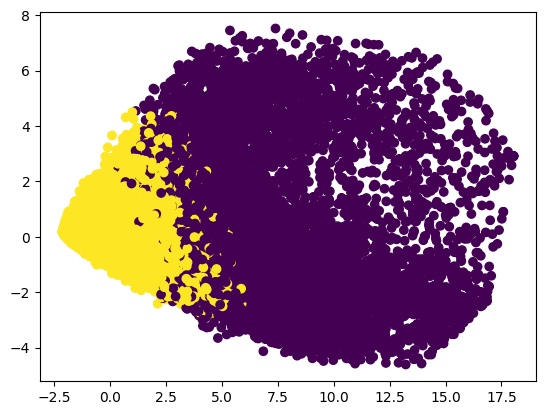

In [10]:
bi.scatter_plot(bi.pca(bi.birch(branching_factor, n_clusters, threshold)))